# Deep Learning
## CNNs for image classification (Fashion-MNIST)
---
>Nikolaos Mavroforos <br>
>nmavroforos@aueb.gr
>Panagiotis Ntenezos <br>
>pntenezo@aueb.gr

**Task:** Given an image of a fashion item, build a deep learning model that recognizes the fashion item. 


In [77]:
# pip install -U keras-applications
# pip install pydot

In [71]:
# TensorFlow and tf.keras
import tensorflow as tf
import kerastuner as kt
import gc
import os

# other important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Callbacks
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import seaborn as sn

import pandas as pd

from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Embedding, GlobalMaxPooling2D, Conv2D, MaxPooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model


from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix

print(tf.__version__)

# keep project path into a variable
current_path = os.getcwd()

2.8.0


### 0. Data manipulation
- The dataset contains 60,000 $28 \times 28$ grayscale images of images associated with a label from 10 fashion categories, along with a test set of 10,000 images.
- We will use a CNN to classify them.

#### Dataset Import & Exploration
- Download dataset using [Keras dataset module](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)
- The values of the inputs are in [0, 255] so we normalize them to [0, 1]
- Output dataset dimensions and counts per label

In [195]:
# function that returns counts per label
def get_label_counts(label_array):
    df_grouped = pd.DataFrame(label_array, columns = ['Label'])
    return df_grouped.groupby(['Label']).agg({'Label':'count'}).rename(columns={'Label':'Count'})

#download dataset
fashion_mnist = tf.keras.datasets.fashion_mnist

# import data to numpy arrays
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scaling
train_images = train_images / 255.0
test_images = test_images / 255.0

# define class names for labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



In [196]:
from sklearn.model_selection import train_test_split

x_train, x_dev, y_train, y_dev = train_test_split(train_images, train_labels, 
                                                  test_size=0.15,
                                                  stratify=train_labels,
                                                  random_state=42)

In [197]:
# print dataset dimensions
print('Train images shape: \t',x_train.shape)
print('Train labels shape: \t',y_train.shape)
print('Dev Train images shape: \t',x_dev.shape)
print('Dev Train labels shape: \t',y_dev.shape)
print('Test images shape: \t',test_images.shape)
print('Test labels shape: \t',test_labels.shape)

print('\nTraining labels counts: \n', get_label_counts(train_labels))
print('Test labels counts: \n', get_label_counts(test_labels))

Train images shape: 	 (51000, 28, 28)
Train labels shape: 	 (51000,)
Dev Train images shape: 	 (9000, 28, 28)
Dev Train labels shape: 	 (9000,)
Test images shape: 	 (10000, 28, 28)
Test labels shape: 	 (10000,)

Training labels counts: 
        Count
Label       
0       6000
1       6000
2       6000
3       6000
4       6000
5       6000
6       6000
7       6000
8       6000
9       6000
Test labels counts: 
        Count
Label       
0       1000
1       1000
2       1000
3       1000
4       1000
5       1000
6       1000
7       1000
8       1000
9       1000


In [198]:
# define parameters
batch_size = 128
classes = 10
epochs = 100
input_shape = (28, 28, 1)

### Image classification using Convolutional Neural Network (CNN)

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

With Conv1D, one dimension only is used, so the convolution operates on the first axis (size 28)(like the text classif.).

With Conv2D, two dimensions are used, so the convolution operates on the two axis defining the data (size (28,28))(like the image classif.).

So we use Conv2D and MaxPooling2D for the same reason



In [199]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [201]:
def train_model(
        optimizer,
        epochs=100,
        batch_size=128,
        conv_layers=2,
        conv_activation='relu',
        conv_dropout=False,
        output_activation='softmax',
        callbacks=None,
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    print("---Setting up model -----")
    
    
    # Define the input layer.
    input = Input(
        shape=input_shape,
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs



### * Simple CNN, with 1 Convolution Layer, no Dropout with Early Stopping with Patience 10

In [202]:
optimizer = Adam()

early_stop = EarlyStopping(monitor="val_loss",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True, 
                           verbose = 1)

conv_no_drop_model_adam, conv_no_drop_hs_adam = train_model(
    optimizer=optimizer,
    epochs=100,
    batch_size=batch_size,
    conv_layers=1,
    conv_activation='relu',
    conv_dropout=False,
    output_activation='softmax', 
    callbacks=[early_stop]
)
conv_no_drop_eval_adam = conv_no_drop_model_adam.evaluate(test_images, test_labels, verbose=1)
clean_up(model=conv_no_drop_model_adam)

---Setting up model -----
Restoring model weights from the end of the best epoch: 29.
Epoch 39: early stopping
Finished training.
------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 8)         0         
                                                                 
 Flatten (Flatten)           (None, 1568)              0         
                                                                 
 Output (Dense)              (None, 10)                15690     
                                                                 
Total params: 15,770
Trainable params: 15,77

In [49]:
# def summarize_diagnostics(history):
#     # plot loss
#     plt.figure()
#     plt.plot(history.history['accuracy'])
#     plt.plot(history.history['val_accuracy'])
#     plt.title('Model Accuracy')
#     plt.ylabel('accuracy')
#     plt.xlabel('epoch')
#     plt.legend(['Train', 'Test'], loc='upper left')
#     plt.show()
    
#     # plot accuracy
#     plt.figure()
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'test'], loc='upper right')
#     plt.show()

In [138]:
def plot_history(hs, epochs, metric):
    print()
    plt.style.use('dark_background')
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


Train Loss     : 0.20335
Validation Loss: 0.30809
Test Loss      : 0.30402
---
Train Accuracy     : 0.92819
Validation Accuracy: 0.89314
Test Accuracy      : 0.89200



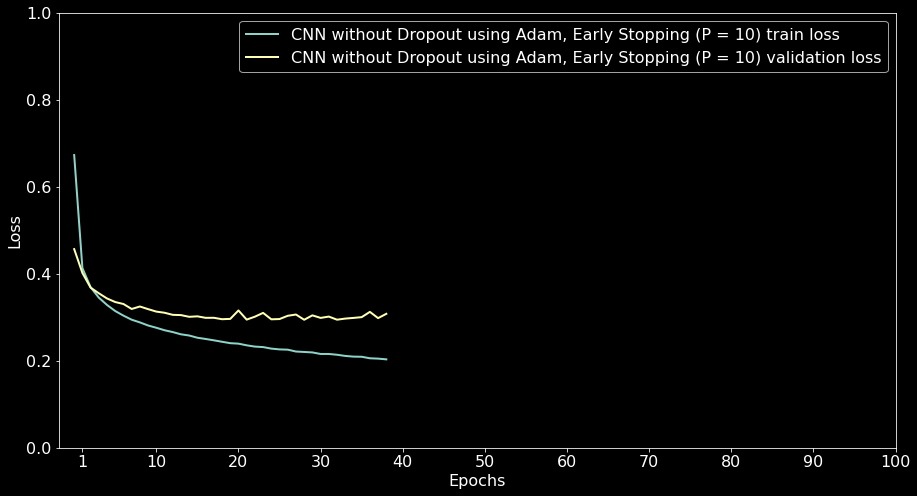

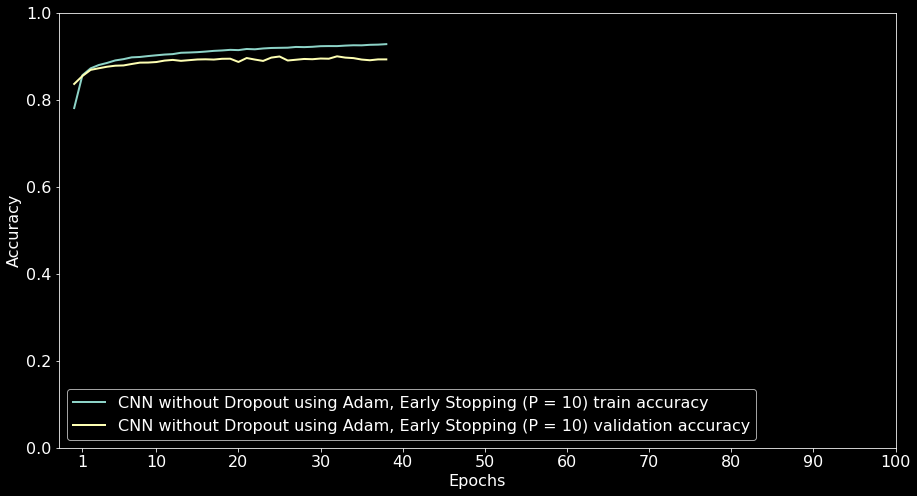

In [142]:
print("Train Loss     : {0:.5f}".format(conv_no_drop_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_no_drop_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_no_drop_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_no_drop_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_no_drop_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_no_drop_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(
    hs={
        'CNN without Dropout using Adam, Early Stopping (P = 10)': conv_no_drop_hs_adam
    },
    epochs=epochs,
    metric='loss'
)
plot_history(
    hs={
        'CNN without Dropout using Adam, Early Stopping (P = 10)': conv_no_drop_hs_adam
    },
    epochs=epochs,
    metric='accuracy'
)

## Predictions

In [143]:
cnn_pred_distribution = conv_no_drop_model_adam.predict(test_images)
cnn_pred_distribution

array([[6.1342803e-08, 4.5298640e-10, 6.4843363e-07, ..., 1.2352151e-02,
        3.0504632e-05, 9.8603988e-01],
       [3.0481999e-05, 6.7737363e-13, 9.9926430e-01, ..., 1.9102335e-21,
        7.6558454e-11, 1.8388706e-12],
       [2.8327563e-07, 9.9999869e-01, 5.9786798e-10, ..., 7.2819583e-15,
        6.4188621e-10, 2.5933283e-12],
       ...,
       [4.2462451e-03, 1.2643270e-08, 2.3228582e-04, ..., 1.9181746e-06,
        9.8996019e-01, 1.7880979e-09],
       [1.1735907e-09, 9.9999833e-01, 8.0078574e-12, ..., 5.0054590e-15,
        2.0553850e-11, 4.0207926e-09],
       [2.1064488e-04, 2.7778049e-05, 4.4906214e-03, ..., 1.3998647e-01,
        3.4450021e-02, 3.1205430e-03]], dtype=float32)

In [145]:
cnn_pred_labels = [np.argmax(p) for p in cnn_pred_distribution]


## Evaluation phase


In [146]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
cnn_acc = accuracy_score(test_labels, cnn_pred_labels)
cnn_acc

0.892

## Error Analysis

In [147]:
misclassified_indices_cnn = np.argwhere(test_labels != cnn_pred_labels)
print('Number of misclassified:', len(misclassified_indices_cnn))

Number of misclassified: 1080


In [148]:
#https://github.com/giorgosfatouros/Deep-Learning-model-for-Fashion-item-recognition/blob/master/deep_learning_model.ipynb
def plot_image(i, predictions, true_labels, img):
    predictions_array, true_label, img = predictions[i], true_labels[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img.reshape(28,28), cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)
    
def plot_value_array(i, predictions, true_labels, show_xticks=False):
    predictions_array, true_label = predictions[i], true_labels[i]
    plt.grid(False)
    plt.xticks([])
    if show_xticks:
        plt.xticks(range(10), class_names, rotation='vertical')
    else:
        plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

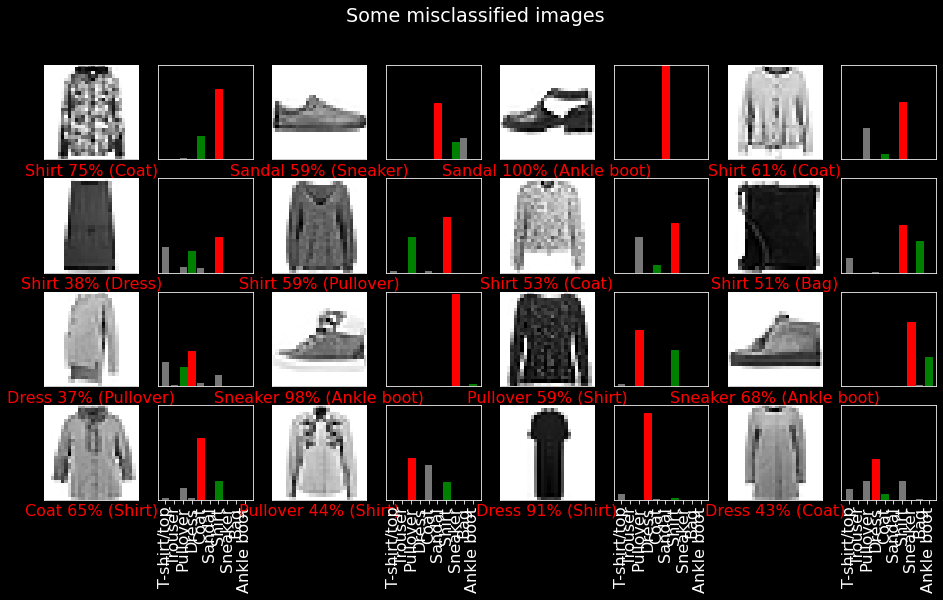

In [149]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
show_x_ticks = False
plt.title('Some images with their distribution/probability of each class')

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(misclassified_indices_cnn[i-1][0], cnn_pred_distribution, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2*i+2)
    plot_value_array(misclassified_indices_cnn[i-1][0], cnn_pred_distribution , test_labels, show_x_ticks)

plt.suptitle('Some misclassified images')
plt.show;

In [150]:
confusion_mlp = confusion_matrix(test_labels, cnn_pred_labels)

print('CNN: Confusion Matrix\n')

df_cm_mlp = pd.DataFrame(confusion_mlp, index = [i for i in class_names],
                  columns = [i for i in class_names])
df_cm_mlp

CNN: Confusion Matrix



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,838,0,21,26,2,1,103,1,8,0
Trouser,1,972,2,17,4,0,2,0,2,0
Pullover,15,2,854,6,60,0,60,0,3,0
Dress,23,7,14,899,20,0,36,0,1,0
Coat,3,0,75,35,830,0,56,0,1,0
Sandal,0,0,0,0,0,972,1,19,0,8
Shirt,127,3,91,28,75,1,669,0,6,0
Sneaker,0,0,0,0,0,16,0,967,0,17
Bag,4,3,0,6,1,2,15,4,965,0
Ankle boot,0,0,0,0,0,7,1,37,1,954


In [151]:
import seaborn as sns

def plot_confusion_matrix(df_cm,name_plot):    
    index = df_cm.index
    index.name = "Actual"

    columns= df_cm.columns
    columns.name = "Predict"

    plt.figure(figsize = (12,9))

    # flights.pivot("month", "year")

    # by default number in float .2 : fmt=.2g, but we want eg.789
    sn.heatmap(df_cm/np.sum(df_cm), annot=True,fmt='.1%',
               cmap=sns.cubehelix_palette(as_cmap=True))

    # fix for mpl bug that cuts off top/bottom of seaborn viz
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.title(name_plot+': Confusion Matrix with percentage %')

    #Rotating axis labels
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    plt.show()

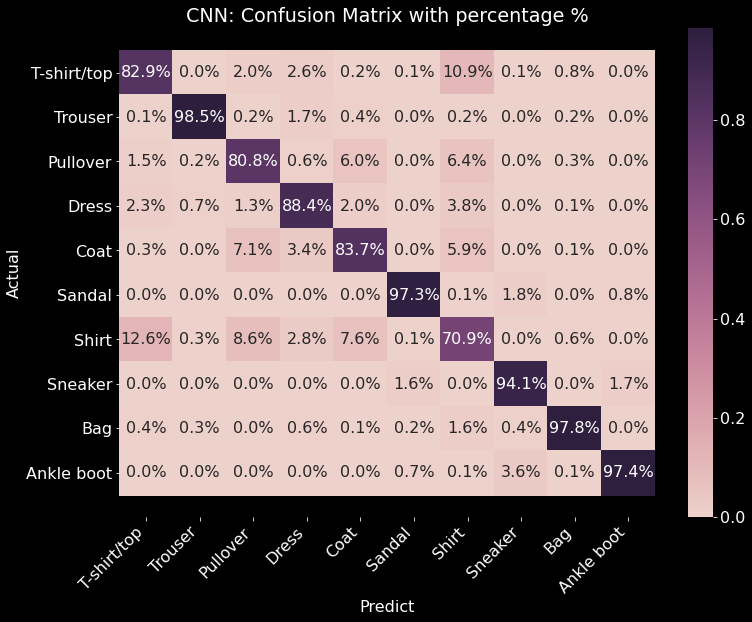

In [152]:
plot_confusion_matrix(df_cm_mlp,'CNN')

### * CNN with 2 Convolution Layers with Dropout 0.2 and early stopping

In [154]:
optimizer = Adam()

early_stop = EarlyStopping(monitor="val_loss",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True, 
                           verbose = 1)

conv_drop_model_adam, conv_drop_hs_adam = train_model(
    optimizer=optimizer,
    epochs=100,
    batch_size=batch_size,
    conv_layers=2,
    conv_activation='relu',
    conv_dropout=False,
    output_activation='softmax', 
    callbacks=[early_stop]
)
conv_drop_eval_adam = conv_drop_model_adam.evaluate(test_images, test_labels, verbose=1)
clean_up(model=conv_drop_model_adam)

---Setting up model -----
Restoring model weights from the end of the best epoch: 35.
Epoch 45: early stopping
Finished training.
------------------
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D-1 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 8)         0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 14, 14, 16)        1168      
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 7, 7, 16)          0         
                                                                 
 Flatten (Flatten)           (None, 784)  

Train Loss     : 0.19460
Validation Loss: 0.28610
Test Loss      : 0.28829
---
Train Accuracy     : 0.93050
Validation Accuracy: 0.90431
Test Accuracy      : 0.89530



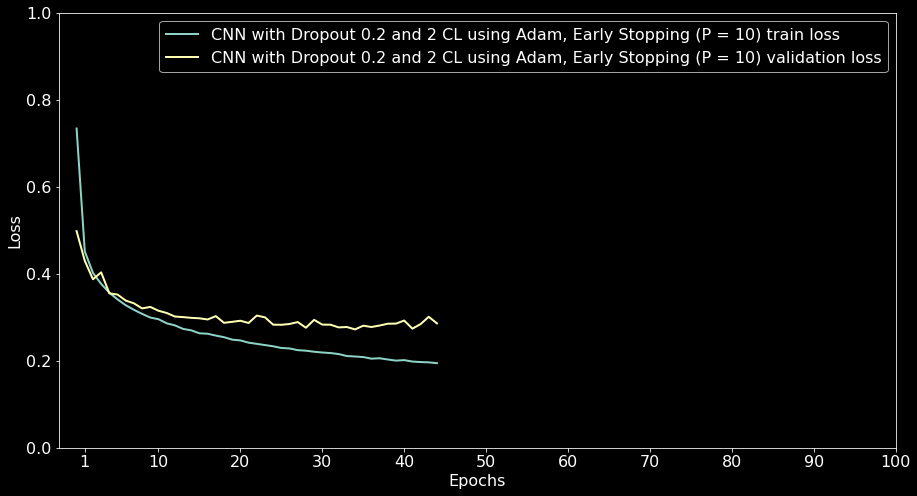

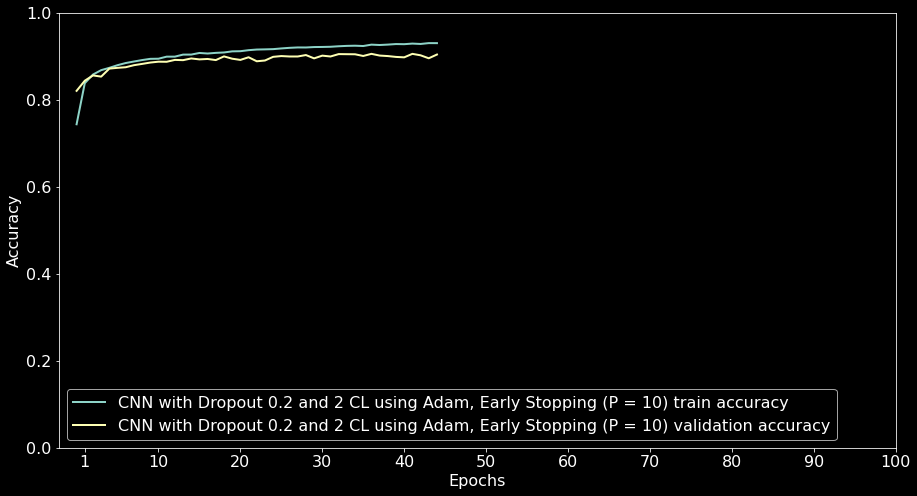

In [155]:
print("Train Loss     : {0:.5f}".format(conv_drop_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(conv_drop_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(conv_drop_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(conv_drop_hs_adam.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(conv_drop_hs_adam.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(conv_drop_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(
    hs={
        'CNN with Dropout 0.2 and 2 CL using Adam, Early Stopping (P = 10)': conv_drop_hs_adam
    },
    epochs=epochs,
    metric='loss'
)
plot_history(
    hs={
        'CNN with Dropout 0.2 and 2 CL using Adam, Early Stopping (P = 10)': conv_drop_hs_adam
    },
    epochs=epochs,
    metric='accuracy'
)

## Predictions

In [156]:
cnn_drop_pred_distribution = conv_drop_model_adam.predict(test_images)
cnn_drop_pred_distribution

array([[2.7193531e-08, 2.0198918e-12, 1.7545947e-08, ..., 9.0134162e-03,
        7.3042647e-05, 9.9003017e-01],
       [2.4871863e-04, 7.9360856e-13, 9.9876320e-01, ..., 2.6269369e-23,
        1.9790967e-11, 1.1812102e-13],
       [7.0693051e-07, 9.9999905e-01, 6.9064299e-10, ..., 9.3120251e-16,
        1.5460945e-09, 1.6173636e-12],
       ...,
       [2.6749607e-05, 1.0086452e-09, 2.5351935e-06, ..., 6.9291900e-10,
        9.9981588e-01, 2.0451720e-11],
       [1.3049047e-08, 9.9999988e-01, 6.8231675e-12, ..., 1.1185766e-14,
        1.3782355e-12, 2.5151834e-12],
       [1.8967017e-05, 4.2506773e-07, 7.2462787e-04, ..., 7.8290232e-02,
        9.9245504e-02, 7.3942880e-04]], dtype=float32)

In [157]:
cnn_drop_pred_labels = [np.argmax(p) for p in cnn_drop_pred_distribution]


## Evaluation phase


In [158]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
cnn_acc = accuracy_score(test_labels, cnn_drop_pred_labels)
cnn_acc

0.8953

## Error Analysis

In [159]:
misclassified_indices_cnn_drop = np.argwhere(test_labels != cnn_drop_pred_labels)
print('Number of misclassified:', len(misclassified_indices_cnn_drop))

Number of misclassified: 1047


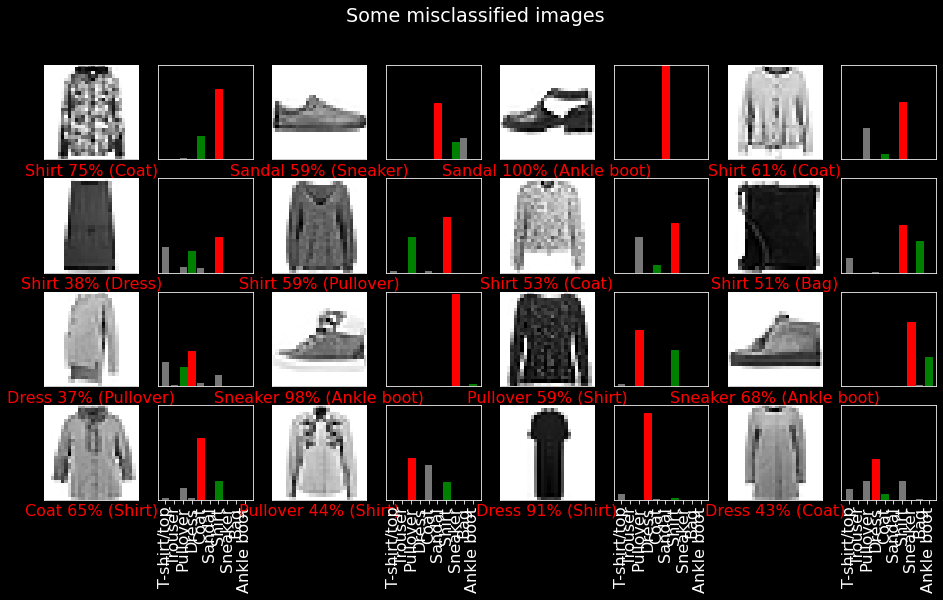

In [160]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
show_x_ticks = False
plt.title('Some images with their distribution/probability of each class')

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(misclassified_indices_cnn[i-1][0], cnn_pred_distribution, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2*i+2)
    plot_value_array(misclassified_indices_cnn[i-1][0], cnn_pred_distribution , test_labels, show_x_ticks)

plt.suptitle('Some misclassified images')
plt.show;

In [161]:
confusion_cnn_drop = confusion_matrix(test_labels, cnn_drop_pred_labels)

print('CNN: Confusion Matrix with Dropout\n')

df_cnn_dropout = pd.DataFrame(confusion_cnn_drop, index = [i for i in class_names],
                  columns = [i for i in class_names])
df_cnn_dropout

CNN: Confusion Matrix with Dropout



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,847,1,15,23,3,0,99,0,12,0
Trouser,2,980,0,11,3,0,2,0,2,0
Pullover,26,2,822,13,67,0,67,0,3,0
Dress,17,8,9,911,21,0,32,0,2,0
Coat,4,0,66,39,825,0,62,0,4,0
Sandal,0,0,0,0,0,972,1,21,0,6
Shirt,135,1,53,32,76,0,692,0,11,0
Sneaker,0,0,0,0,0,15,0,974,0,11
Bag,3,2,2,6,3,0,5,4,975,0
Ankle boot,0,0,1,0,0,6,0,38,0,955


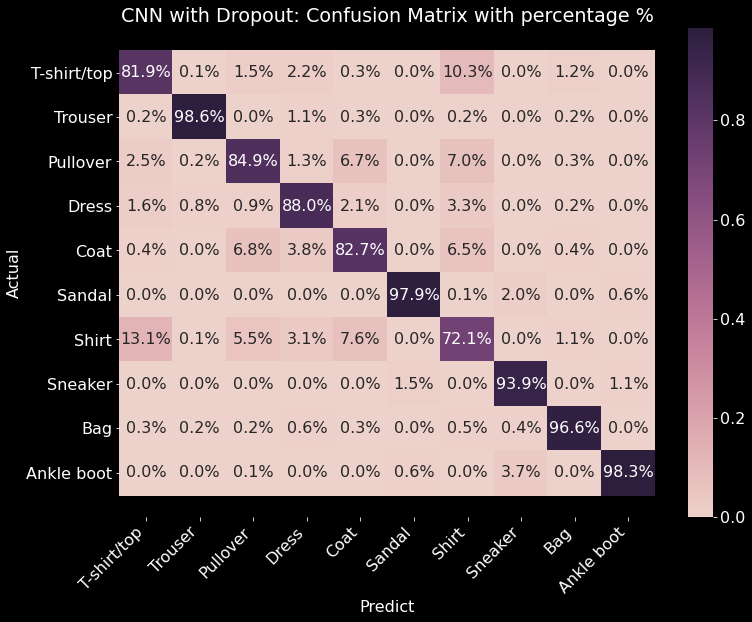

In [162]:
plot_confusion_matrix(df_cnn_dropout,'CNN with Dropout')

#### CNN Model with hyperparameter tuning
* Hyperband is an optimized variation of random search which uses early-stopping to speed up the process. The underlying principle of the procedure exploits the idea that if a hyperparameter configuration is expected to be the best after a considerable number of iterations, it is more likely to perform after a small number of iterations. The main idea is to fit many models for a small number of epochs and only to continue training for the models achieving the highest accuracy on the validation set. (https://www.marktechpost.com/2021/03/20/optimizing-hyperparameters-using-the-keras-tuner-framework/)

* Implement model builder and tune on number of `convolution layers`, `initial number of filters`,`kernel size`, `dropout rates`, `learning rate`, `batch size` and number of `epochs`

In [168]:
from keras.layers import GlobalAveragePooling2D

def model_builder(hp):
    """######################################################################### """
    # Tune the activation function in the first and second Dense layer
    # Choose an optimal value from 'relu', 
    hp_act = hp.Choice('activation', 
                       values=(
                           'relu', 
                           'tanh', 
                           'selu',
                               ),
                       default = 'relu',
                       )
    # Tune the number of units in the Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', 
                        min_value=32, 
                        max_value=512, 
                        step=32)
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=(1e-2, 1e-3, 1e-4))
    # Tune the dropout
    # Choose an optimal value from 0 to 0.6
    hp_dropout_1 = hp.Float('dropout_1',
                        min_value = 0,
                        max_value = .6,
                        step = .2,
                        default = .4)
    hp_dropout_2 = hp.Float('dropout_2',
                        min_value = 0,
                        max_value = .6,
                        step = .2,
                        default = .4)
    # Tune the filters
    hp_filters_1 = hp.Choice('num_filters_1',
                        values=(16, 32, 64),
                        default=32,
                        )
    hp_filters_2 = hp.Choice('num_filters_2',
                        values=(16, 32, 64),
                        default=32,
                        )
    """######################################################################### """
    # FILTERS = 32
    KERNEL = (3, 3)

    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(Conv2D( filters = hp_filters_1, 
                    kernel_size = KERNEL, 
                    activation = hp_act, 
                    kernel_initializer = 'he_uniform',
                    input_shape = (28, 28, 1)))
    # cnn_model.add(BatchNormalization())

    cnn_model.add(MaxPooling2D(pool_size=(2, 2),
                            strides=None, 
                            padding="valid"))
    cnn_model.add(Dropout(hp_dropout_1))

    ##"valid" means no padding. "same" results in padding evenly to the 
    ##left/right or up/down of the input such that output has the same
    ##height/width dimension as the input.
    
    cnn_model.add(Conv2D( filters = hp_filters_2, 
                    kernel_size = KERNEL, 
                    activation = hp_act))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2),
                            strides=None, 
                            padding="valid"))
    cnn_model.add(Dropout(hp_dropout_1))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=hp_units, activation=hp_act))
    cnn_model.add(Dropout(hp_dropout_2))
    cnn_model.add(Dense(classes, activation='softmax'))

    cnn_model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    return cnn_model

tuner_cnn = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir_cnn',
                     project_name='intro_to_kt_cnn')

early_stop_2 = EarlyStopping(monitor="val_loss",
                           mode="min", 
                           patience=10, 
                           restore_best_weights=True)

tuner_cnn.search(x_dev,
            y_dev,  
             epochs=100, 
             validation_split = 0.1, 
             callbacks=[early_stop_2])

# Get the optimal hyperparameters
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)[0]

Trial 31 Complete [00h 00m 47s]
val_accuracy: 0.7922222018241882

Best val_accuracy So Far: 0.8678333163261414
Total elapsed time: 00h 01m 39s
INFO:tensorflow:Oracle triggered exit


In [169]:
print(f"""
The hyperparameter search is complete:
The optimal number of filter of first Con2d is {best_hps_cnn.get('num_filters_1')}
The optimal number of filter of second Con2d is {best_hps_cnn.get('num_filters_2')}
The optimal number of units in the densely-connected layer is {best_hps_cnn.get('units')}
The optimal number of dropout in the between the Convo is {best_hps_cnn.get('dropout_2')}

The optimal number of dropout in the densely-connected layer is {best_hps_cnn.get('dropout_2')}
The optimal activation function for all layers is {best_hps_cnn.get('activation')}
The optimal learning rate for the optimizer is {best_hps_cnn.get('learning_rate')}
""")


The hyperparameter search is complete:
The optimal number of filter of first Con2d is 64
The optimal number of filter of second Con2d is 64
The optimal number of units in the densely-connected layer is 448
The optimal number of dropout in the densely-connected layer is 0.6000000000000001
The optimal activation function for all layers is relu
The optimal learning rate for the optimizer is 0.001



In [171]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model_cnn = tuner_cnn.hypermodel.build(best_hps_cnn)
history_cnn = model_cnn.fit(x_train, y_train,  
             epochs=100, 
             validation_split=0.1, 
             callbacks=[early_stop])

# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch: %d' % (best_epoch,))

# hypermodel = tuner.hypermodel.build(best_hps)

# # Retrain the model with the best epoch
# hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=(x_valid, y_valid))

eval_result_cnn = model_cnn.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result_cnn)

Epoch 1/100
1435/1435 [==============================] - 34s 24ms/step - loss: 0.6369 - accuracy: 0.7677 - val_loss: 0.4055 - val_accuracy: 0.8473
Epoch 2/100
1435/1435 [==============================] - 33s 23ms/step - loss: 0.4327 - accuracy: 0.8420 - val_loss: 0.3599 - val_accuracy: 0.8645
Epoch 3/100
1435/1435 [==============================] - 34s 23ms/step - loss: 0.3802 - accuracy: 0.8610 - val_loss: 0.3146 - val_accuracy: 0.8831
Epoch 4/100
1435/1435 [==============================] - 33s 23ms/step - loss: 0.3541 - accuracy: 0.8711 - val_loss: 0.2956 - val_accuracy: 0.8898
Epoch 5/100
1435/1435 [==============================] - 34s 24ms/step - loss: 0.3385 - accuracy: 0.8759 - val_loss: 0.2790 - val_accuracy: 0.8986
Epoch 6/100
1435/1435 [==============================] - 33s 23ms/step - loss: 0.3256 - accuracy: 0.8803 - val_loss: 0.2742 - val_accuracy: 0.8961
Epoch 7/100
1435/1435 [==============================] - 33s 23ms/step - loss: 0.3140 - accuracy: 0.8834 - val_loss: 0

In [181]:
def summarize_diagnostics(history):
    # plot loss
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Final Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # plot accuracy
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Final Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

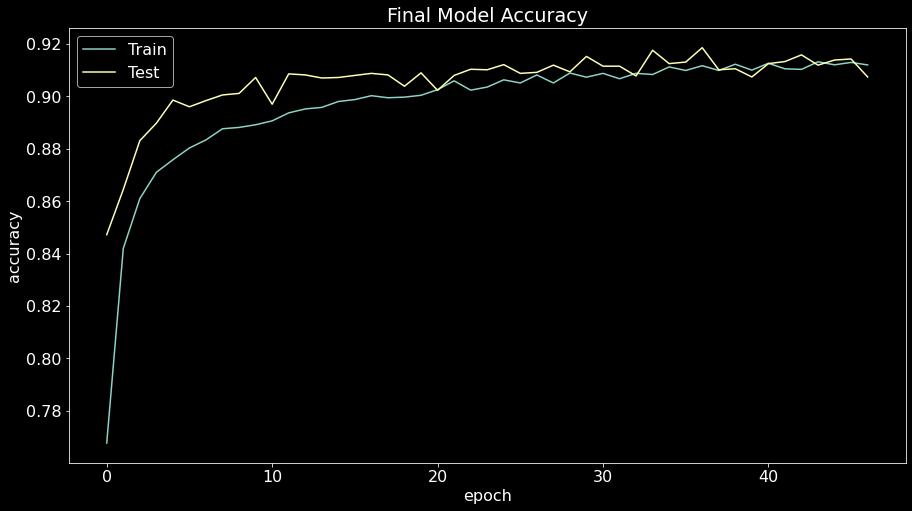

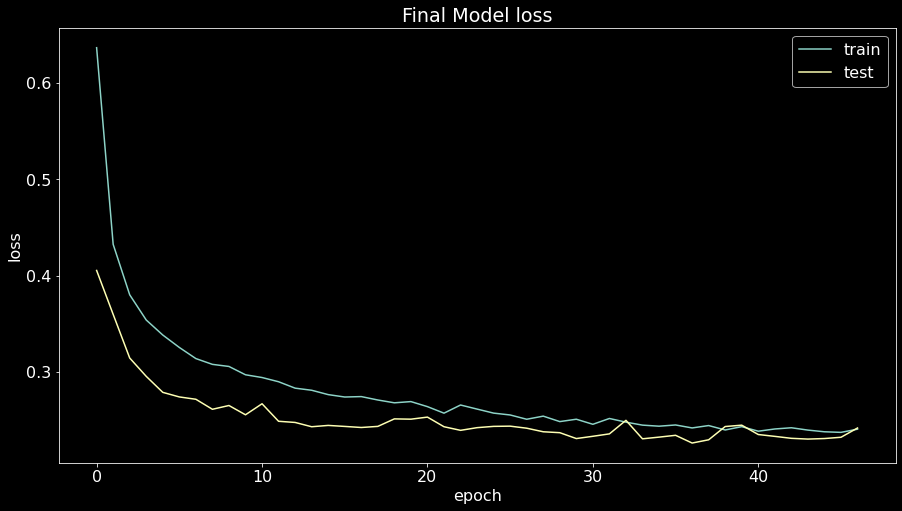

In [182]:
summarize_diagnostics(history_cnn)

In [194]:
print("Train Loss     : {0:.5f}".format(history_cnn.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(history_cnn.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(eval_result_cnn[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(history_cnn.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(history_cnn.history['val_accuracy'][-1]))
print("Test Accuracy      : {0:.5f}".format(eval_result_cnn[1]))


# # Plot train and validation error per epoch.
# plot_history(
#     hs={
#         'CNN with Dropout 0.2 and 2 CL using Adam, Early Stopping (P = 10)': history_cnn
#     },
#     epochs=epochs,
#     metric='loss'
# )
# plot_history(
#     hs={
#         'CNN with Dropout 0.2 and 2 CL using Adam, Early Stopping (P = 10)': history_cnn
#     },
#     epochs=epochs,
#     metric='accuracy'
# )

Train Loss     : 0.24073
Validation Loss: 0.24195
Test Loss      : 0.24059
---
Train Accuracy     : 0.91205
Validation Accuracy: 0.90745
Test Accuracy      : 0.91250


## Predictions

In [186]:
cnn_final_distribution = model_cnn.predict(test_images)
cnn_final_distribution

array([[1.3881398e-16, 5.5172381e-17, 2.6121904e-17, ..., 2.3476609e-06,
        2.7289841e-15, 9.9999654e-01],
       [8.8637699e-07, 1.6031066e-13, 9.9971718e-01, ..., 1.5242789e-19,
        3.8660546e-09, 2.8679193e-18],
       [1.2472171e-19, 1.0000000e+00, 5.6065894e-21, ..., 9.8901567e-34,
        3.0818279e-22, 9.5620881e-35],
       ...,
       [1.7569602e-19, 6.1349082e-23, 7.8173104e-20, ..., 8.8010012e-23,
        1.0000000e+00, 5.3243008e-26],
       [9.2036807e-17, 1.0000000e+00, 8.4260371e-19, ..., 9.1998988e-30,
        2.9899413e-21, 1.1467244e-30],
       [3.1835265e-05, 7.3416572e-07, 1.2263024e-05, ..., 5.3023931e-02,
        9.9304598e-04, 1.8560832e-03]], dtype=float32)

In [188]:
cnn_final_pred_labels = [np.argmax(p) for p in cnn_final_distribution]


## Evaluation phase


In [189]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
cnn_acc = accuracy_score(test_labels, cnn_final_pred_labels)
cnn_acc

0.9125

## Error Analysis

In [190]:
misclassified_indices_cnn_final = np.argwhere(test_labels != cnn_final_pred_labels)
print('Number of misclassified:', len(misclassified_indices_cnn_final))

Number of misclassified: 875


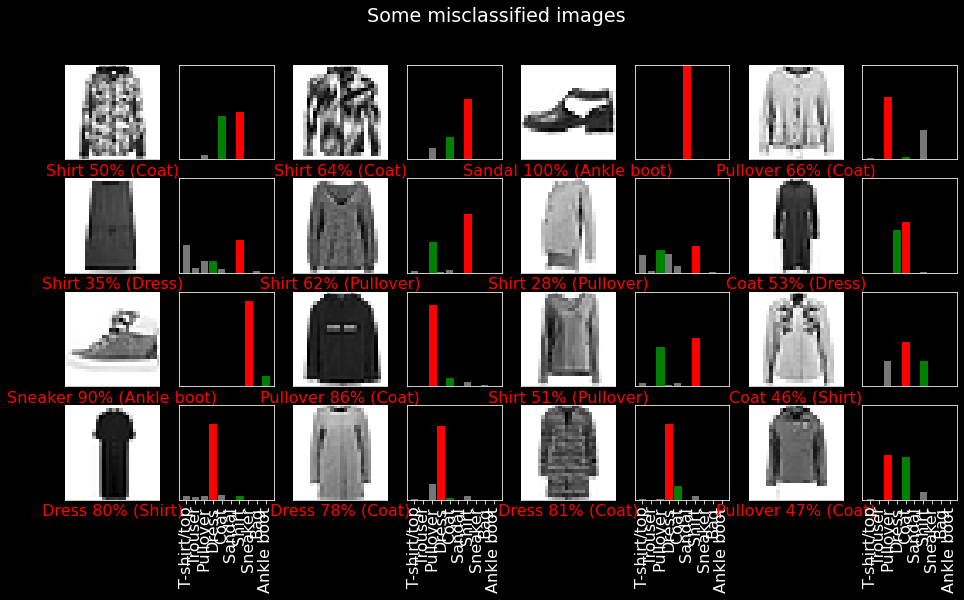

In [191]:
num_rows = 4
num_cols = 4
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
show_x_ticks = False
plt.title('Some images with their distribution/probability of each class')

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(misclassified_indices_cnn_final[i-1][0], cnn_final_distribution, test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2*i+2)
    plot_value_array(misclassified_indices_cnn_final[i-1][0], cnn_final_distribution , test_labels, show_x_ticks)

plt.suptitle('Some misclassified images')
plt.show;

In [192]:
confusion_cnn_drop = confusion_matrix(test_labels, cnn_final_pred_labels)

print('CNN: Confusion Matrix\n')

df_cnn_final = pd.DataFrame(confusion_cnn_drop, index = [i for i in class_names],
                  columns = [i for i in class_names])
df_cnn_final

CNN: Confusion Matrix



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,867,1,11,16,2,1,98,0,4,0
Trouser,3,982,0,9,2,0,2,0,2,0
Pullover,15,0,877,10,32,0,66,0,0,0
Dress,14,4,8,931,14,0,28,0,1,0
Coat,0,0,53,36,830,0,81,0,0,0
Sandal,0,0,0,0,0,976,0,16,0,8
Shirt,107,0,68,25,50,0,747,0,3,0
Sneaker,0,0,0,0,0,5,0,988,0,7
Bag,0,0,5,5,1,2,7,3,977,0
Ankle boot,0,0,0,0,0,5,0,45,0,950


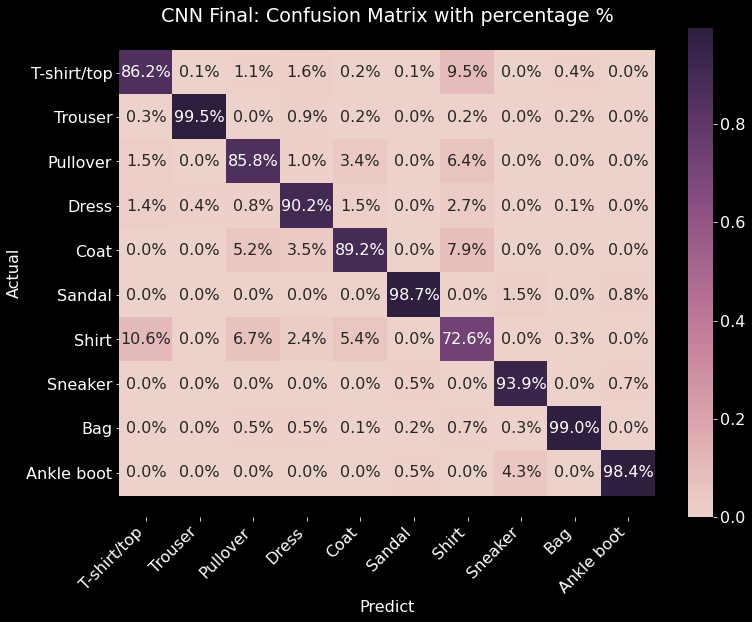

In [193]:
plot_confusion_matrix(df_cnn_final,'CNN Final')

### 3. Image classification with VGG19

In [14]:
# define model builder
def model_builder_vgg(hp):
    
    np.random.seed(94) # Define the seed for numpy to have reproducible experiments.
    set_seed(49) # Define the seed for Tensorflow to have reproducible experiments.

    base_model = VGG19(
        include_top=False,
        weights='imagenet',
        input_shape = (32, 32, 3),
        pooling='max',
    )
    
    input_tensor = Input(shape=(28, 28 ,1) )
    x = tf.keras.layers.experimental.preprocessing.Resizing(
        32, 32, interpolation="bilinear", name='resize_layer'
    )(input_tensor)
    x = Conv2D(3,(3,3),padding='same')(x)    # x has a dimension of (32,32,3)
    x = base_model (x) 
    
    # Define MLP layers.
    for i in range(2):
        x = Dense(
            units=1024,
            activation='relu',
            kernel_initializer='glorot_uniform',
            name='Hidden-{0:d}'.format(i)
            )(x)
        x = Dropout(
            rate=hp.Choice('dropout_' + str(i), values=[0.0, 0.1, 0.2]),
            name='Dropout-{0:d}'.format(i)
            )(x)
    x = Dense(
        units=512,
        activation=hp.Choice('activation_2', values=['relu','tanh']),
        kernel_initializer='glorot_uniform',
        name='Hidden-2'
        )(x)
    x = Dropout(
        rate=hp.Choice('dropout_2', values=[0.0, 0.1, 0.2]),
        name='Dropout-2'
        )(x)
    
    # Define the output layer.
    output = Dense(
        units=classes,
        activation='softmax',
        name='Output'
    )(x)
    
    # Define the model and train it.
    model = Model(inputs=input_tensor, outputs=output)
    
    # only train upper layers
    if base_trainable==False:
        learning_rate=1e-3 #learning rate for upper model
        for layer in base_model.layers:
            layer.trainable = True
    else:
    # train full model
        learning_rate=1e-5 #learning rate for full model
        for layer in base_model.layers:
            layer.trainable = False
    
    model.compile(optimizer=Adam(learning_rate=learning_rate)
                  ,loss='categorical_crossentropy'
                  ,metrics=['accuracy']
                 )
    
    return model

ValueError: All callbacks used during a search should be deep-copyable (since they are reused across trials). It is not possible to do `copy.deepcopy([<keras.callbacks.EarlyStopping object at 0x00000225506B8B80>, <keras.callbacks.ReduceLROnPlateau object at 0x00000225133AF6A0>])

In [16]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[64, 128, 256, 512])
        kwargs['epochs'] = 20  
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [19]:
#define custom early stopping class
class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

# define call back to stop training when a monitored metric has stopped improving
early_stop = ReturnBestEarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# define call back for to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.1,
    patience=2,
    cooldown=2,
    verbose=1
)

In [38]:
# # define custom tuner
# base_trainable=False
# vgg_tuner = MyTuner(model_builder_vgg,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=2,
#                      directory='VGG Tuner_Results_Dir',
#                      project_name='Fashion-Mnist-Hyperband CNN'
#                    )

# # search for best configuration
# vgg_tuner.search(x_train, y_train, validation_split=0.1, callbacks=[early_stop, reduce_lr])